# Modal synthesis

> Tools for computing the modes of an object using the finite element method

In [ ]:
#| default_exp modal

In [ ]:
# | export
from enum import Enum
from functools import cache, cached_property
from typing import NamedTuple, Optional, Union

import numpy as np
from skfem import (
    asm,
    condense,
    Basis,
    BilinearForm,
    ElementTriP2,
    ElementVector,
    Mesh2D,
    MeshTri,
    solve,
    solver_eigen_scipy_sym,
)
from skfem.helpers import dot
from skfem.models.elasticity import linear_elasticity
import torch

In [ ]:
# | hide

import IPython.display as ipd
from matplotlib import pyplot as plt
from neuralresonator.utilities import save_and_display_audio

## Rendering utilities

In [ ]:
# | export

def eigenvalue_to_frequency(eigenvalues):
    return eigenvalues**0.5 / (2 * np.pi)

def frequency_to_eigenvalue(frequencies):
    return (frequencies * (2 * np.pi ))**2

In [ ]:
# | export

def render_modes(
    frequency: Union[torch.Tensor, np.ndarray],  # Mode frequencies
    decay: Union[torch.Tensor, np.ndarray],  # Mode decay parameters
    amplitude: Union[torch.Tensor, np.ndarray],  # Mode amplitudes
    initial_phase: Optional[
        Union[torch.Tensor, np.ndarray]
    ] = None,  # Mode initial phases
    length_in_samples: int = 44100,  # Length of the output signal in samples
    sample_rate: float = 44100,  # Sample rate of the output signal
    return_sum: bool = True,  # Return the sum of the modes
) -> Union[torch.Tensor, np.ndarray]:  # Rendered signal
    "Renders a batch of modes given their parameters."

    backend = torch if isinstance(frequency, torch.Tensor) else np

    initial_phase = (
        backend.zeros_like(frequency) if initial_phase is None else initial_phase
    )
    angular_frequency = 2 * np.pi * frequency
    time_axis = backend.arange(length_in_samples) / sample_rate
    envelope = backend.exp(-decay[..., None] * time_axis)
    sinusoids = backend.cos(
        angular_frequency[..., None] * time_axis + initial_phase[..., None]
    )
    signal = envelope * sinusoids * amplitude[..., None]
    return signal.sum(-2) if return_sum else signal

def render_modes_coeffs(
    eigenvalues: Union[np.ndarray, torch.Tensor],
    eigenvectors: Union[np.ndarray, torch.Tensor],
    alpha: float,
    beta: float,
    length_in_samples: int = 44100,
    sample_rate: int = 44100,
):
    """
    Renders a batch of modes given damping coefficients.
    """

    damping_coeffs = 0.5 * (alpha + beta * eigenvalues)
    damped_freqs = eigenvalues - damping_coeffs**2
    damped_freqs[damped_freqs < 0] = 0
    damped_freqs = eigenvalue_to_frequency(damped_freqs)
    modes = render_modes(damped_freqs,
                         damping_coeffs,
                         eigenvectors,
                         length_in_samples=length_in_samples,
                         sample_rate=sample_rate,)
    return modes

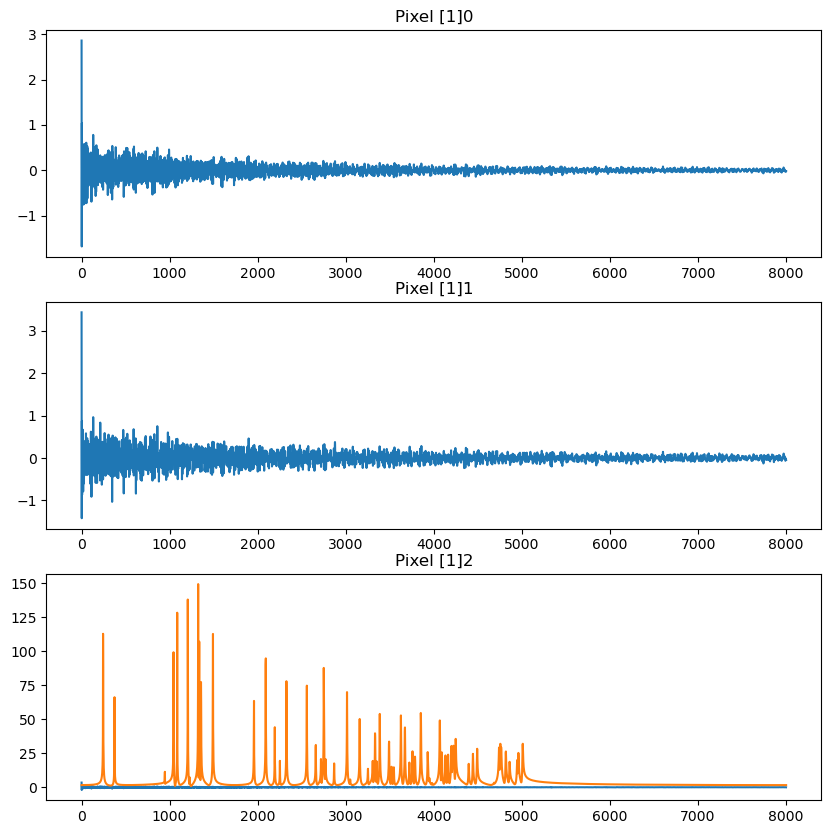

<StemContainer object of 3 artists>

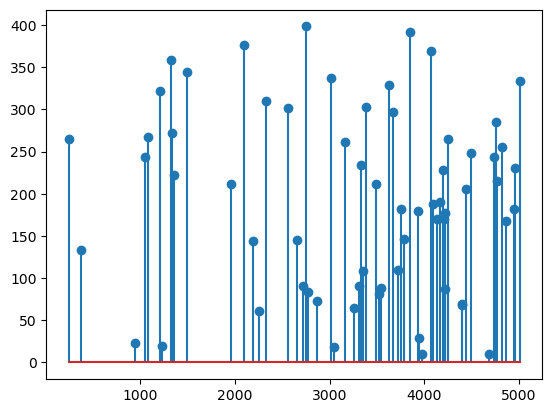

In [ ]:
# vals go from 1e9 to 1e10
vals = torch.rand(1, 64) * 1e9
vecs = torch.rand(1, 3, 3, 64) * 0.1
alpha = 5
beta = 4e-8
sr = 16000
audio = render_modes_coeffs(vals, vecs, alpha, beta, int(sr * 0.5), sr)

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i in range(3):
    axs[i].plot(audio[0][1][i].numpy())
    axs[i].set_title(f"Pixel [1]{i}")
    ipd.display(ipd.Audio(audio[0][1][i].numpy(), rate=sr))

target_fft = torch.fft.rfft(audio[0, 0, 0, :]).abs()

freq = torch.fft.rfftfreq(audio.shape[-1], 1/sr)
plt.plot(freq.numpy(), target_fft.numpy())
plt.show()

damping_coeffs = 0.5 * (alpha + beta * vals[0])
damped_freqs = vals[0] - damping_coeffs**2
damped_freqs[damped_freqs < 0] = 0
damped_freqs = eigenvalue_to_frequency(damped_freqs)

plt.stem(damped_freqs.numpy(), vecs[0, 0, 0].numpy() * 4001)

### Examples

Generating a single decaying mode:

[<matplotlib.lines.Line2D>]

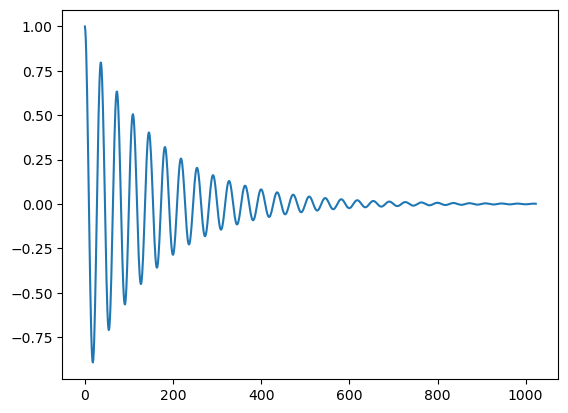

In [ ]:
frequency = torch.tensor([440.0])
decay = torch.tensor([100.0])
amplitude = torch.ones(1)
length_in_samples = 1024
sample_rate = 16000.0

signal = render_modes(frequency, decay, amplitude, None, length_in_samples, sample_rate)
plt.plot(signal)


## Modal synthesis

In [ ]:
# | export

def create_mesh(n_refinements: int = 5):
    "Initialise a triangular mesh with `n_refinements` refinements."
    return MeshTri().refined(n_refinements)

def create_basis(mesh: Mesh2D):
    "Construct a cell basis for the mesh."
    element = ElementTriP2()
    element_vector = ElementVector(element)
    return Basis(mesh, element_vector)

In [ ]:
# | export

def scale(value: float, range: tuple[float, float]) -> float:
    "Scale a value to a given range."
    return (value - range[0]) / (range[1] - range[0])

def unscale(value: float, range: tuple[float, float]) -> float:
    "Unscale a value from a given range."
    return value * (range[1] - range[0]) + range[0]

class MaterialRanges(NamedTuple):
    "Ranges for material properties."
    rho: tuple[float, float] = (500.0, 10000.0)  # material density
    E: tuple[float, float] = (1e9, 1e12)  # Young's modulus
    nu: tuple[float, float] = (0.0, 0.5)  # Poisson's number
    alpha: tuple[float, float] = (1.0, 30.0)  # Rayleigh damping coefficient $\alpha$
    beta: tuple[float, float] = (1e-8, 2e-6)  # Rayleigh damping coefficient $\beta$

default_material_ranges = MaterialRanges()

class Material(NamedTuple):
    "Material properties."
    rho: float  # material density
    E: float  # Young's modulus
    nu: float  # Poisson's number
    alpha: float  # Rayleigh damping coefficient $\alpha$
    beta: float  # Rayleigh damping coefficient $\beta$
    
    @classmethod
    def random(cls, generator: Optional[np.random.Generator] = None):
        "Create a random material."
        rnd = np.random.default_rng() if generator is None else generator
        return cls(
            rho=rnd.uniform(*default_material_ranges.rho),
            E=rnd.uniform(*default_material_ranges.E),
            nu=rnd.uniform(*default_material_ranges.nu),
            alpha=rnd.uniform(*default_material_ranges.alpha),
            beta=rnd.uniform(*default_material_ranges.beta),
        )

    @classmethod
    def set_default_ranges(cls, ranges: MaterialRanges):
        "Set the default ranges for material properties."
        global default_material_ranges
        default_material_ranges = ranges

    def scaled(self):
        "Scale material properties to the given range."
        return Material(**{ 
            k: scale(v, getattr(default_material_ranges, k)) for k, v in self._asdict().items()
        })

    def unscaled(self):
        "Unscale material properties from the given range."
        return Material(**{
            k: unscale(v, getattr(default_material_ranges, k)) for k, v in self._asdict().items()
        })

MATERIALS = dict(
    ceramic=Material(2700, 7.2e10, 0.19, 6, 1e-7),
    glass=Material(2600, 6.2e10, 0.20, 1, 1e-7),
    wood=Material(750, 1.0e10, 0.25, 60, 2e-6),
    plastic=Material(1070, 1.4e9, 0.35, 30, 1e-6),
    iron=Material(8000, 2.1e11, 0.28, 5, 1e-7),
    polycarbonate=Material(1190, 2.4e9, 0.37, 0.5, 4e-7),
    steel=Material(7850, 2.0e11, 0.29, 5, 3e-8),
    custom=Material(8000, 2.1e11, 0.49, 5, 1e-7),
)

In [ ]:
# | hide

material = Material.random()
scaled_material = material.scaled()
unscaled_material = scaled_material.unscaled()
assert material == unscaled_material

array_from_material = np.array([*material])
material_from_array = Material(*array_from_material)
assert material == material_from_array

array_from_material = torch.tensor([*material])
material_from_array = Material(*array_from_material)
assert material == material_from_array


In [ ]:
# | export

class System:
    """Defines an enumeration across materials, with vibrational modes given as a
    property of the material object."""

    def __init__(
        self,
        material: Material,  # material properties
        mesh: Optional[Mesh2D] = None,  # mesh
        basis: Optional[Basis] = None,  # basis
        k: int = 128,  # number of modes to compute
        force_cache: bool = False,  # force caching at init
    ):
        self.rho = material.rho
        self.E = material.E
        self.nu = material.nu
        self.alpha = material.alpha
        self.beta = material.beta
        self.mu = self.E / (2 * (1 + self.nu))
        self.lam = self.E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
        self._mesh = mesh
        self._basis = basis
        self.k = k

        #! Force caching at init
        #! This should not be done, however it
        #! is unclear why pytorch_lighting reset the cache at each call 
        if force_cache:
            self.modes

    def mass(self, u, v, *args):
        return self.rho * dot(u, v)

    @cached_property
    def mesh(self) -> Mesh2D:
        return create_mesh() if self._mesh is None else self._mesh

    @cached_property
    def basis(self) -> Basis:
        return create_basis(self.mesh) if self._basis is None else self._basis

    @cached_property
    def modes(self) -> tuple[np.ndarray, np.ndarray]:  # (eigenvalues, eigenvectors)
        "Construct and solve the eigenvalue problem for the material."
        # define bilinear form
        mass = BilinearForm(lambda *args: self.mass(*args))

        # assemble stiffness and mass matrices
        elasticity = linear_elasticity(self.lam, self.mu)
        K = asm(elasticity, self.basis)
        M = asm(mass, self.basis)

        # set boundary conditions
        D = self.basis.get_dofs()
        I = self.basis.complement_dofs(D)

        # solve the system
        eigenvalues, eigenvectors = solve(
            *condense(K, M, D=D), solver=solver_eigen_scipy_sym(k=self.k)
        )

        return eigenvalues, eigenvectors

    @cached_property
    def eigenvalues(self) -> np.ndarray:
        "Return the eigenvalues of the system."
        return self.modes[0]

    @cached_property
    def eigenvectors(self) -> np.ndarray:
        "Return the eigenvalues of the system."
        return self.modes[1]

    @cached_property
    def damping_coefficients(self) -> np.ndarray:
        "Computes modal damping coefficients for the material."
        return 0.5 * (self.alpha + self.beta * self.eigenvalues)

    @cached_property
    def damped_frequencies(self) -> np.ndarray:
        "Computes damped modal frequencies for the material."
        damped_frequencies = self.eigenvalues - self.damping_coefficients**2
        damped_frequencies[damped_frequencies < 0] = 0
        damped_frequencies = eigenvalue_to_frequency(damped_frequencies)
        return damped_frequencies

    @cache
    def get_mode_gains(self,
                       node: Optional[int] = None,
    ) -> np.ndarray:
        "Computes mode gains for the material."

        # has shape [DOFs x nodes x modes]
        s = self.eigenvectors[self.basis.nodal_dofs]
        locs = self.basis.doflocs[:, self.basis.nodal_dofs[0, :].flatten()]

        # transpose to [nodes x modes x DOFs]
        mode_gains = np.transpose(s, (1, 2, 0))
        if node is not None:
            mode_gains = mode_gains[node]

        # normalize gains
        # direction = np.ones(2)
        # mode_gains = (mode_gains @ direction) 

        mode_gains = np.sqrt(mode_gains[...,0]**2 + mode_gains[...,1]**2)

        return mode_gains

    def render(
        self,
        length_in_seconds: float,
        sample_rate: float = 44100,
        initial_phase: Optional[Union[torch.Tensor, np.ndarray]] = None,
        impulse_node_idx: int = 6, # node to apply impulse to (default is 6 center node)
        truncate_modes: Optional[int] = None,  # truncate the number of modes to render
    ):
        "Render the modes of the material."
        length_in_samples = int(length_in_seconds * sample_rate)
        return render_modes(
            self.damped_frequencies[-truncate_modes:]
            if truncate_modes
            else self.damped_frequencies,
            self.damping_coefficients[-truncate_modes:]
            if truncate_modes
            else self.damping_coefficients,
            self.get_mode_gains(impulse_node_idx)[-truncate_modes:]
            if truncate_modes
            else self.get_mode_gains(impulse_node_idx),
            initial_phase,
            length_in_samples,
            sample_rate,
        )


The modes of an object are obtained by solving the second order differential equation

$$
Ku + C\dot{u} + M\ddot{u} = f
$$

where $K$ is the stiffness matrix, $C$ is the damping matrix and $M$ is the damping matrix. $f$ is the force we apply to the system. To solve for the natural modes of the system we set $f = 0$.

We define a mesh using the material properties **density** or $\rho$, **young modulus** or $E$, **poisson number** or $\nu$, and **Rayleigh damping coefficients** $\alpha$ and $\beta$

The Lamé parameters are then given by
$$
   \lambda = \frac{E}{2(1 + \nu)}, \quad \mu = \frac{E \nu}{(1+ \nu)(1 - 2 \nu)},
$$
<!-- https://doc.comsol.com/5.5/doc/com.comsol.help.sme/sme_ug_modeling.05.083.html -->
<!-- https://geotechsimulation.com/2018/04/09/rayleigh-and-numerical-damping-in-finite-element-analysis/ -->


To retrieve the vibrational modes, we must follow three steps:

1. Assemble the stiffness and desitity matrices
2. Set the boundary conditions (set degrees of freedom, by setting zeroes in the matrices)
3. Solve the generalised eigenvalue problem

These steps are performed by the `Material.modes` property, which returns a tuple `(eigenvalues, eigenvectors)`. This is cached for each instantiation to solve computation time if subsequent evaluations are required, e.g. in constructing a dataset.

The `Material` enumeration also provides a `damped_frequencies` property — also cached — which applies the formula:

$$
\omega_{i}=\frac{1}{2 \pi} \sqrt{\lambda_{i}-\left(\frac{\alpha+\beta \lambda_{i}}{2}\right)^{2}}
$$

to derive the frequencies, where $\lambda_i$ are the eigenvalues.

## Example usage

/tmp/ipykernel_80158/1503038420.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


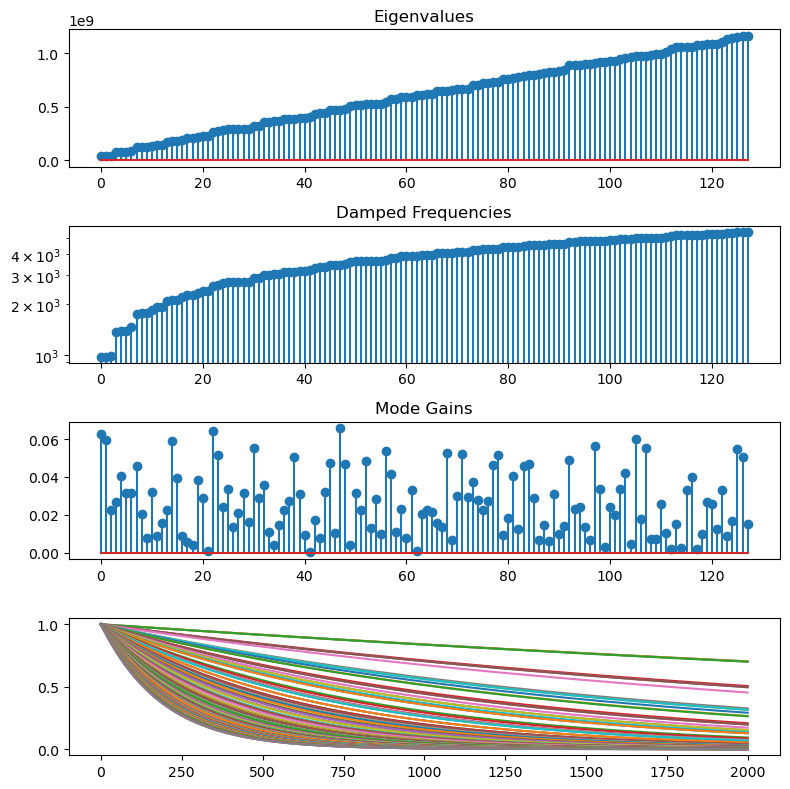

In [ ]:
m = MATERIALS["polycarbonate"]
s = System(m)

fig, axs = plt.subplots(4, 1, figsize=(8, 8))

# plot the eigenvalues
axs[0].stem(s.eigenvalues)
axs[0].set_title("Eigenvalues")

# plot the damped frequencies
axs[1].stem(s.damped_frequencies)
axs[1].set_title("Damped Frequencies")
axs[1].set_yscale("log")

# plot node gains
axs[2].stem(np.abs(s.get_mode_gains(100)))
axs[2].set_title("Mode Gains")

# plot amplitude envelopes given by damping coefficients
axs[3].plot(
    np.exp(-s.damping_coefficients * np.linspace(0, 2000.0 / 44100.0, 2000)[..., None])
)

fig.tight_layout()
fig.show()


Rendering audio from predefined materials:

In [ ]:
#| eval:false

f_s = 44100
T = 0.75
num_modes = 64
mesh = create_mesh(n_refinements=4)

# get the dimensions of the mesh
x_min, x_max = mesh.p[0].min(), mesh.p[0].max()
y_min, y_max = mesh.p[1].min(), mesh.p[1].max()


print(f"Mesh dimensions: {x_max - x_min} x {y_max - y_min}")
print(f"Mesh bounding box: ({x_min}, {y_min}) - ({x_max}, {y_max})")

for m in MATERIALS:
    s = System(MATERIALS[m], k=num_modes, mesh=mesh)
    signal = s.render(T, f_s)
    print(f"{m.lower()}:")
    save_and_display_audio(signal, f"{m.lower()}.wav", f_s)


Mesh dimensions: 1.0 x 1.0
Mesh bounding box: (0.0, 0.0) - (1.0, 1.0)
ceramic:


glass:


wood:


plastic:


iron:


polycarbonate:


steel:


custom:


In [ ]:
#| eval:false
num_modes = 32
custom_ranges = MaterialRanges(
    rho=(500, 20000),
    E=(2e10, 5e10),
    nu=(2, 2.11),
    alpha=(1, 12),
    beta=(1e-6, 2e-6),
)

Material.set_default_ranges(custom_ranges)
material = Material.random()
mesh = create_mesh(n_refinements=2)
center_idx = mesh.nodes_satisfying(lambda x: (x[0] == .5) & (x[1] == .5))
print(f"center node: {center_idx}")
s = System(material, k=num_modes, mesh=mesh)
signal = np.clip(s.render(T, f_s, impulse_node_idx=int(center_idx)), -1, 1)
save_and_display_audio(signal, f"custom.wav", f_s)

center node: [6]


Rendering audio from randomly generated materials:

In [ ]:
#| eval: false

f_s = 44100
T = 0.75

for i in range(4):
    m = Material.random()
    s = System(m)
    signal = s.render(T, f_s)
    print(f'Material {i} — {m}:')
    save_and_display_audio(signal, f'random_{i}.wav', f_s)


Material 0 — Material(rho=10491.494936687797, E=23738481498.480457, nu=2.0589013931967086, alpha=11.987371289699409, beta=1.4941768366743795e-06):


Material 1 — Material(rho=18149.675239893957, E=41527152275.70115, nu=2.036596716834167, alpha=5.864244986055844, beta=1.6198757753683198e-06):


Material 2 — Material(rho=15295.51395426235, E=37207269181.088165, nu=2.0699158213124256, alpha=3.4064759996172103, beta=1.7399038626686502e-06):


Material 3 — Material(rho=10707.976358395857, E=20442477271.769733, nu=2.0415409164909177, alpha=7.575957672808222, beta=1.1207046599371003e-06):
